In [1]:
# Нам для управления энергией в микрогриде необходим прогноз/оценка мощности потребления именно на такой то гаризонт. Нам нужны именно такие то знания. Нужно построить универсальный фраймворк / модель системы упрвления для того чтобы тестировать разные подходы, сформировать рекоммендации и предложить окончательное обоснованное решение. Прогнозирование мощности потребления в микрогриде.

# Import

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

import plotly.express as px
import matplotlib.pyplot as plt

from timezonefinder import TimezoneFinder

from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)

from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

from models.models import TimeSeriesModel, ConsumptionModelMean, ConsumptionModelFEDOT, GRUbasedModel, SARIMAXBasedModel, LSTNetBasedModel, HoltWintersBasedModel
from models.alex_model import ModelSetupConfig, ArchitectureConfig, TrainingConfig

import warnings

# Set notebook session settings

# Constants

In [3]:
DATA_PATH = "psh_microgrid_total_power.csv"

LATITUDE = 18.852
LONGITUDE = 98.994
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)

TIMESTAMP_COLUMN = "timestamp"
VALUE_COLUMN = "total_power"
FEATURES = [TIMESTAMP_COLUMN, VALUE_COLUMN]

# Utils

In [4]:
def get_history(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    history = timeseries[timestamp - pd.Timedelta(hours=hours_n) : timestamp - pd.Timedelta(hours=1)]
    if len(history) != hours_n:
        return None
    # print(type(history))
    return history

In [5]:
def get_actual_forecast(timeseries: pd.DataFrame, timestamp: pd.Timestamp, hours_n: int) -> pd.DataFrame:
    actual_forecast = timeseries[timestamp : timestamp  + pd.Timedelta(hours=hours_n-1)]
    if len(actual_forecast) != hours_n:
        return None
    # print(type(actual_forecast))
    return actual_forecast

In [6]:
def simulate_on_timestamp(model: TimeSeriesModel, timeseries: pd.DataFrame, timestamp: pd.Timestamp, history_length, forecast_length):
    history = get_history(timeseries, timestamp, history_length)
    actual = get_actual_forecast(timeseries, timestamp, forecast_length)
    if history is None or actual is None:
        return None
    forecast = model.forecast(history)
    return [history, actual, forecast]

def collect_simulation_on_timestamp_results(simulation_on_timestamp_results):
    [history, actual, forecast] = simulation_on_timestamp_results
    merged_data = pd.merge(history, history, left_index=True, right_index=True)
    merged_data = merged_data.rename(columns={f'{VALUE_COLUMN}_x': 'actual', f'{VALUE_COLUMN}_y': 'model'})
    merged_data["error"] = np.zeros(len(history))
    
    merged_data_next = pd.DataFrame(actual)
    merged_data_next = merged_data_next.rename(columns={VALUE_COLUMN: 'actual'})
    merged_data_next["model"] = forecast
    merged_data_next["error"] = merged_data_next["actual"]- merged_data_next["model"]
    
    return pd.concat([merged_data, merged_data_next])

In [7]:
# def sample_modeling_on_next_hour(sample: pd.DataFrame, model: TimeSeriesModel) -> pd.DataFrame:
#     timestamps = sample.index
#     timestamps_realised = []
#     actuals = []
#     forecasts = []
#     for timestamp in tqdm(timestamps):
#         simulation_on_timestamp_results = simulate_on_timestamp(model, sample, timestamp)
#         if simulation_on_timestamp_results is None:
#             continue
#         [history, actual, forecast] = simulation_on_timestamp_results
#         actual = actual[VALUE_COLUMN]
#         timestamps_realised.append(timestamp)
#         actuals.append(actual[0])
#         forecasts.append(forecast[0])
#     result_dict = {"timestamp": timestamps_realised, "actual": actuals, "model": forecasts}
#     result_df = pd.DataFrame(result_dict).set_index("timestamp")
#     return result_df

In [8]:
# def sample_modeling(sample: pd.DataFrame, model: TimeSeriesModel, forecasting_step: int) -> pd.DataFrame:
#     pass

In [9]:
def simulate_on_timeseries(model: TimeSeriesModel, timeseries: pd.DataFrame, history_length, forecast_length):
    timestamps = timeseries.index
    timestamps_realised = []
    errors_on_hours = [[] for _ in range(forecast_length)]
    actuals_on_hours = [[] for _ in range(forecast_length)]
    forecasts_on_hours = [[] for _ in range(forecast_length)]
    RMSE_list = []
    R2_list = []
    R2_list_2 = []
    MAE_list = []
    MAPE_list = []
    SMAPE_list = []
    corr_list = []
    for timestamp in tqdm(timestamps):
        simulation_on_timestamp_results = simulate_on_timestamp(model, timeseries, timestamp, history_length, forecast_length)
        if simulation_on_timestamp_results is None:
            continue
        [history, actual_forecast, forecast] = simulation_on_timestamp_results
        actual_forecast = actual_forecast[VALUE_COLUMN]
        timestamps_realised.append(timestamp)
        for i in range(forecast_length):
            errors_on_hours[i].append(actual_forecast[i] - forecast[i])
            actuals_on_hours[i].append(actual_forecast[i])
            forecasts_on_hours[i].append(forecast[i])
        RMSE_list.append(mean_squared_error(actual_forecast, forecast))
        SS_res = np.sum((actual_forecast - forecast)**2)
        actual_forecast_m = np.ones(len(actual_forecast)) * np.mean(actual_forecast)
        SS_tot = np.sum((actual_forecast - actual_forecast_m)**2)
        R2_list_2.append(1 - ((SS_res) / (SS_tot)))
        R2_list.append(r2_score(actual_forecast, forecast))
        MAE_list.append(mean_absolute_error(actual_forecast, forecast))
        MAPE_list.append(np.mean(np.abs((actual_forecast - forecast) / actual_forecast)))
        SMAPE_list.append(1/len(actual_forecast) * np.sum(2 * np.abs(actual_forecast - forecast) / (np.abs(actual_forecast) + np.abs(forecast))))
        corr_list.append(np.corrcoef(forecast, actual_forecast)[0,1])
    assessment_result_dict = {
            "timestamp": timestamps_realised, 
            "RMSE": RMSE_list,
            "R2": R2_list,
            "R2_2": R2_list_2,
            "MAE": MAE_list,
            "MAPE": MAPE_list,
            "SMAPE": SMAPE_list,
            "corr": corr_list,
        }
    for i in range(forecast_length):
        assessment_result_dict[f"errors_{i}"] = errors_on_hours[i]
        assessment_result_dict[f"actuals_{i}"] = actuals_on_hours[i]
        assessment_result_dict[f"forecasts_{i}"] = forecasts_on_hours[i]
    assessment_result_df = pd.DataFrame(assessment_result_dict)
    return assessment_result_df

In [10]:
def error_scoring(actual: np.ndarray, forecast: np.ndarray) -> dict:
    error = actual - forecast
    ME = np.mean(error)
    MAE = np.mean(np.absolute(error))
    MAPE = np.mean(np.abs((actual - forecast) / actual))
    SMAPE = 1/len(actual) * np.sum(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))
    # MAPE_2 = mean_absolute_percentage_error(actual, forecast)
    RMSE = np.sqrt(np.dot(error, error) / len(error))
    # RMSE_2 = np.sqrt(np.mean(error**2))
    # RMSE_3 = np.sqrt(mean_squared_error(actual, forecast))
    STD = np.std(error)
    # error_ = error - np.ones(len(error)) * ME
    # STD_2 = np.sqrt(np.mean(error_**2))
    R2 = r2_score(actual, forecast)
    # SS_res = np.sum((actual - forecast)**2)
    # actual_forecast_m = np.ones(len(actual)) * np.mean(actual)
    # SS_tot = np.sum((actual - actual_forecast_m)**2)
    # R2_2 = 1 - ((SS_res) / (SS_tot))
    corr = np.corrcoef(forecast, actual)[0,1]
    return {
    "ME": ME,
    "MAE": MAE,
    "MAPE": MAPE,
    "SMAPE": SMAPE,
    "RMSE": RMSE,
    "STD": STD,
    "R2": R2,
    "corr": corr
}

In [11]:
def collect_metrics(assessment_result_df, forecast_length):
    hours = []
    for i in range(forecast_length):
        hours.append(error_scoring(assessment_result_df[f"actuals_{i}"], assessment_result_df[f"forecasts_{i}"]))
    metrics_df = pd.DataFrame(
            {
        "ME": [hours[i]["ME"] for i in range(forecast_length)],
        "MAE": [hours[i]["MAE"] for i in range(forecast_length)],
        "MAPE": [hours[i]["MAPE"] for i in range(forecast_length)],
        "SMAPE": [hours[i]["SMAPE"] for i in range(forecast_length)],
        "RMSE": [hours[i]["RMSE"] for i in range(forecast_length)],
        "STD": [hours[i]["STD"] for i in range(forecast_length)],
        "R2": [hours[i]["R2"] for i in range(forecast_length)],
        "corr": [hours[i]["corr"] for i in range(forecast_length)]
    }
    )
    return metrics_df

# Data load

In [12]:
df = pd.read_csv(DATA_PATH, usecols=[TIMESTAMP_COLUMN, VALUE_COLUMN], parse_dates=[TIMESTAMP_COLUMN]) # skiprows=[1, 2]

# Data preprocessing

In [13]:
df[TIMESTAMP_COLUMN] = pd.to_datetime(df[TIMESTAMP_COLUMN], utc=False)
df[TIMESTAMP_COLUMN] = df[TIMESTAMP_COLUMN].dt.tz_convert(TIMEZONE)
df = df.sort_values(by=TIMESTAMP_COLUMN)
df = df.set_index(TIMESTAMP_COLUMN)

# Data Splitting

In [14]:
timestamp_for_split = pd.Timestamp(year=2023, month=5, day=1, tz=TIMEZONE)

In [15]:
df_train = df[:timestamp_for_split]
df_test = df[timestamp_for_split:]

In [16]:
segment = get_actual_forecast(df_test, timestamp_for_split, 7*24)

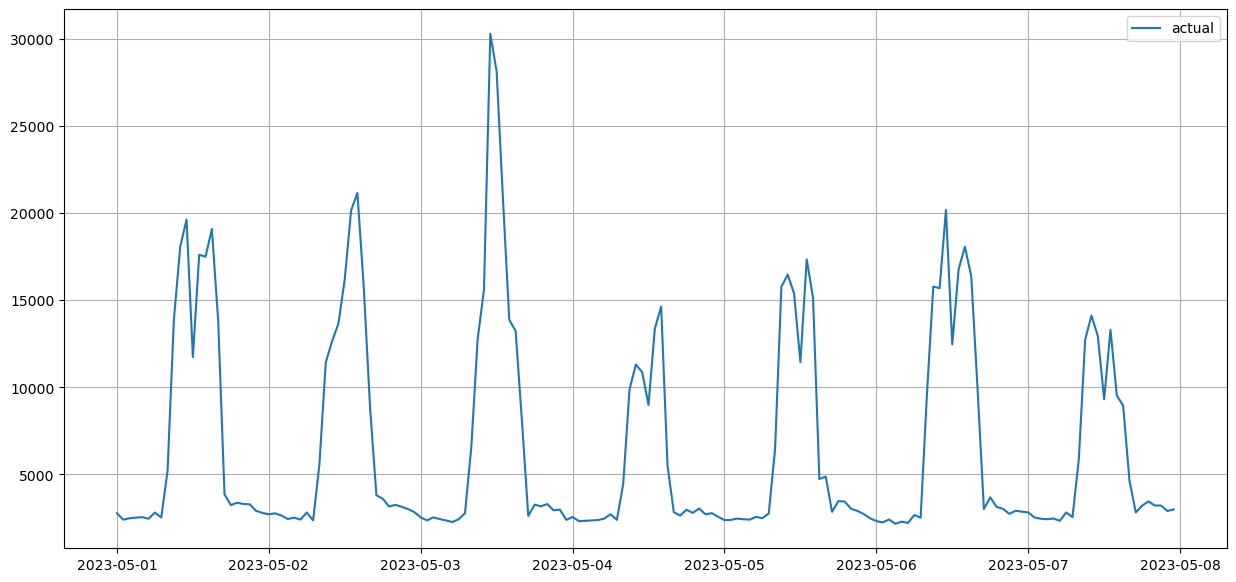

In [17]:
plt.figure(figsize=(15, 7))
# plt.plot(forecast, color="r", label="model")
# plt.axvspan(df.index[-FORECAST_HORIZON], df.index[-1], alpha=0.5, color="lightgrey")
plt.plot(segment, label="actual")
plt.legend()
plt.grid(True)
plt.show()

# FEDOT

In [18]:
HISTORY_LENGTH_FEDOT = 48
FORECAST_LENGTH_FEDOT = 6

In [19]:
# train_data_for_FEDOT_path = "train_data_for_FEDOT.csv"
# df_train.to_csv(train_data_for_FEDOT_path)
model_FEDOT = ConsumptionModelFEDOT(value_column=VALUE_COLUMN,
                                    history_length=HISTORY_LENGTH_FEDOT, 
                                    forecast_length=FORECAST_LENGTH_FEDOT, 
                                    init_model_path="model_fedot_psh_48_6.pkl", 
                                    data_file_path=None # train_data_for_FEDOT_path
)

/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The identity link alias is deprecated. Use Identity instead. The identity link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_power link alias is deprecated. Use InversePower instead. The inverse_power link alias will be removed after the 0.15.0 release.
  warnings.warn(
/home/eduard/anaconda3/envs/modeling_control/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The inverse_squared link alias is deprecated. Use

In [20]:
model_FEDOT.best_pipeline.show()

AttributeError: 'ConsumptionModelFEDOT' object has no attribute 'best_pipeline'

In [ ]:
model_FEDOT.metrics_on_test

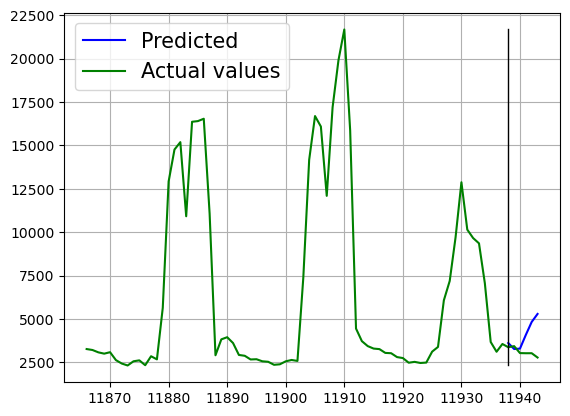

In [22]:
model_FEDOT.plot_prediction_on_test_result()

In [21]:
# model_fedot_psh_path = "model_fedot_psh_48_6.pkl"
# model_FEDOT.save_model(model_fedot_psh_path)

<Axes: xlabel='timestamp'>

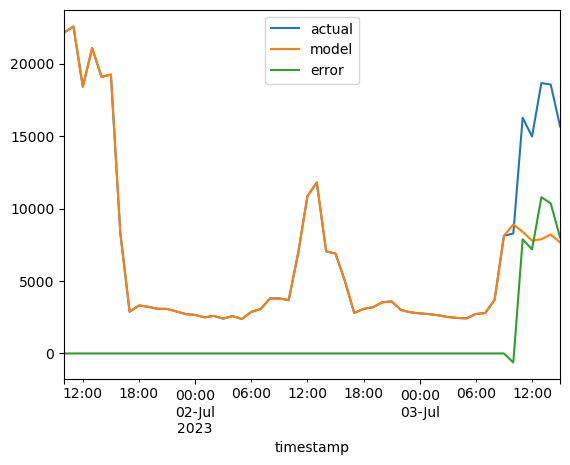

In [23]:
timestamp_validation = pd.Timestamp(year=2023, month=7, day=3, hour=10, tz=TIMEZONE)
collect_simulation_on_timestamp_results(simulate_on_timestamp(model_FEDOT, 
                                       df_test, timestamp_validation, HISTORY_LENGTH_FEDOT, FORECAST_LENGTH_FEDOT)).plot()

In [24]:
assessment_result_df = simulate_on_timeseries(model_FEDOT, df_test, HISTORY_LENGTH_FEDOT, FORECAST_LENGTH_FEDOT)

100%|██████████| 3529/3529 [00:22<00:00, 156.40it/s]


In [25]:
assessment_result_df

,timestamp,RMSE,R2,R2_2,MAE,MAPE,SMAPE,corr,errors_0,actuals_0,...,forecasts_2,errors_3,actuals_3,forecasts_3,errors_4,actuals_4,forecasts_4,errors_5,actuals_5,forecasts_5
0,2023-05-03 00:00:00+07:00,9.604969e+05,-96.899618,-96.899618,812.106922,0.344492,0.454500,0.714202,-338.638214,2544.366,...,2803.932032,441.983906,2441.970,1999.986094,1358.145721,2362.809,1004.663279,1728.281864,2273.073,544.791136
1,2023-05-03 01:00:00+07:00,3.783689e+05,-53.465349,-53.465349,518.165794,0.212900,0.185782,0.755755,-685.709310,2363.136,...,3305.955074,-439.569698,2362.809,2802.378698,-112.530058,2273.073,2385.603058,-91.026158,2431.577,2522.603158
2,2023-05-03 02:00:00+07:00,2.655413e+06,-102.323350,-102.323350,1542.597955,0.626584,0.466084,0.328719,-509.041619,2541.792,...,3997.150379,-1851.874825,2273.073,4124.947825,-1875.818453,2431.577,4307.395453,-2096.413054,2780.705,4877.118054
3,2023-05-03 03:00:00+07:00,5.438893e+06,-1.278863,-1.278863,2023.685426,0.814460,0.533375,0.663119,-974.761786,2441.970,...,4957.556826,-3095.736039,2431.577,5527.313039,-3347.989717,2780.705,6128.694717,-123.725403,6581.860,6705.585403
4,2023-05-03 04:00:00+07:00,9.074049e+06,0.385807,0.385807,2407.612894,0.625831,0.486730,0.783042,-875.220616,2362.809,...,4924.835579,-2807.652248,2780.705,5588.357248,416.871143,6581.860,6164.988857,5996.724064,12767.606,6770.881936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3143,2023-10-05 07:00:00+07:00,3.452053e+07,-0.571972,-0.571972,5043.525629,0.534942,0.622392,0.715925,-1354.587315,3522.214,...,5428.085700,10426.151156,16024.065,5597.913844,6608.178469,12450.607,5842.428531,4046.149147,10006.421,5960.271853
3144,2023-10-05 08:00:00+07:00,7.525893e+07,-1.808263,-1.808263,7525.486950,0.559860,0.798761,0.789344,-744.079859,3003.378,...,4746.378897,7377.702055,12450.607,5072.904945,4816.410253,10006.421,5190.010747,14143.133237,19655.796,5512.662763
3145,2023-10-05 09:00:00+07:00,1.131596e+08,-6.677115,-6.677115,10062.429621,0.666040,1.008746,0.609806,7569.311269,11061.661,...,4705.745781,5107.195311,10006.421,4899.225689,14431.512989,19655.796,5224.283011,13669.122627,19371.399,5702.276373
3146,2023-10-05 10:00:00+07:00,6.171222e+07,-4.003466,-4.003466,6616.672338,0.380206,0.506274,-0.268337,3990.118593,16024.065,...,8506.926954,11633.170402,19655.796,8022.625598,10900.606657,19371.399,8470.792343,9696.944049,17047.811,7350.866951


In [26]:
assessment_result_df.mean()

/tmp/ipykernel_5665/152922769.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  assessment_result_df.mean()


RMSE           2.219253e+07
R2            -1.529638e+02
R2_2          -1.529638e+02
MAE            3.172135e+03
MAPE           6.307957e-01
SMAPE          5.957255e-01
corr           3.545817e-01
errors_0       3.067691e+02
actuals_0      6.067959e+03
forecasts_0    5.761190e+03
errors_1       6.354461e+02
actuals_1      6.060332e+03
forecasts_1    5.424886e+03
errors_2       9.142878e+02
actuals_2      6.058321e+03
forecasts_2    5.144033e+03
errors_3       1.125926e+03
actuals_3      6.050820e+03
forecasts_3    4.924894e+03
errors_4       1.329636e+03
actuals_4      6.047328e+03
forecasts_4    4.717692e+03
errors_5       1.528675e+03
actuals_5      6.039045e+03
forecasts_5    4.510370e+03
dtype: float64

In [27]:
metrics_FEDOT = collect_metrics(assessment_result_df, FORECAST_LENGTH_FEDOT)

In [28]:
metrics_FEDOT

,ME,MAE,MAPE,SMAPE,RMSE,STD,R2,corr
0,306.769058,1771.471159,0.322281,0.318896,2954.252118,2938.281525,0.734218,0.858553
1,635.446061,2778.181914,0.548985,0.521515,4154.679802,4105.797433,0.471266,0.696050
2,914.287803,3373.890997,0.676323,0.624747,4860.017990,4773.243413,0.275584,0.548838
3,1125.925770,3576.975687,0.722601,0.663671,5105.331494,4979.628583,0.199033,0.488247
4,1329.635924,3706.304138,0.743660,0.699396,5288.854065,5118.988731,0.140609,0.445985
5,1528.675262,3825.986266,0.770924,0.746128,5432.315734,5212.792551,0.090035,0.415965


In [29]:
# Sample plotting
...

# AlexGRU

In [30]:
HISTORY_LENGTH_Alex = 24
FORECAST_LENGTH_Alex = 6

In [31]:
model_setup_config = ModelSetupConfig(train_df = df_train.reset_index(),
                                      architecture_config = ArchitectureConfig(
                                          input_dim = HISTORY_LENGTH_Alex + 4,
                                          output_dim = FORECAST_LENGTH_Alex,
                                          hidden_dim = 4096,
                                          layer_dim = 1,
                                          dropout_prod = 0,
                                          bidirectional = False,
                                          multitarget = True
                                      ),
                                      training_config = TrainingConfig(
                                          batch_size = 512,
                                          n_epochs = 20,
                                          gamma = 0.95,
                                          learning_rate = 1e-3 * 8,
                                          weight_decay = 1e-6
                                      )
                                      )

In [63]:
model_alex_GRU = GRUbasedModel(timestamp_column=TIMESTAMP_COLUMN,
                               target_column=VALUE_COLUMN, 
                               history_length=HISTORY_LENGTH_Alex, 
                               forecast_length=FORECAST_LENGTH_Alex, 
                               init_model_path=None,
                               model_setup_config=model_setup_config)

[1/20] Training loss: 53180135.68182	 Validation loss: 61459792.00000
[2/20] Training loss: 45577442.65909	 Validation loss: 53500036.00000
[3/20] Training loss: 39341136.31818	 Validation loss: 47789584.00000
[4/20] Training loss: 35056599.84091	 Validation loss: 43776708.00000
[5/20] Training loss: 32100814.15341	 Validation loss: 40903856.00000
[6/20] Training loss: 30018876.01705	 Validation loss: 38792668.00000
[7/20] Training loss: 28514298.22159	 Validation loss: 37184492.00000
[8/20] Training loss: 27395248.35795	 Validation loss: 35935444.00000
[9/20] Training loss: 26537149.20455	 Validation loss: 34946468.00000
[10/20] Training loss: 25858955.43182	 Validation loss: 34130676.00000
[20/20] Training loss: 20532868.13636	 Validation loss: 27879304.00000


In [64]:
model_alex_GRU.alex_preprocessed_train_df

,total_power,hour,season,cos_month,sin_month,lag0,lag1,lag2,lag3,lag4,...,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23
23,"[22914.599, 21259.456, 15576.415, 15476.405, 9...",14,0,-1.0,1.224647e-16,24038.690,22486.669,8356.707,10682.806,13636.056,...,2343.301,2539.219,6170.751,6202.816,6395.020,6270.340,6417.736,8098.858,17697.354,23922.065
24,"[21259.456, 15576.415, 15476.405, 9333.498, 60...",15,0,-1.0,1.224647e-16,22914.599,24038.690,22486.669,8356.707,10682.806,...,2055.773,2343.301,2539.219,6170.751,6202.816,6395.020,6270.340,6417.736,8098.858,17697.354
25,"[15576.415, 15476.405, 9333.498, 6026.601, 597...",16,0,-1.0,1.224647e-16,21259.456,22914.599,24038.690,22486.669,8356.707,...,1885.756,2055.773,2343.301,2539.219,6170.751,6202.816,6395.020,6270.340,6417.736,8098.858
26,"[15476.405, 9333.498, 6026.601, 5975.034, 5762...",17,0,-1.0,1.224647e-16,15576.415,21259.456,22914.599,24038.690,22486.669,...,2109.199,1885.756,2055.773,2343.301,2539.219,6170.751,6202.816,6395.020,6270.340,6417.736
27,"[9333.498, 6026.601, 5975.034, 5762.615, 1995....",18,0,-1.0,1.224647e-16,15476.405,15576.415,21259.456,22914.599,24038.690,...,1980.815,2109.199,1885.756,2055.773,2343.301,2539.219,6170.751,6202.816,6395.020,6270.340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11933,"[7055.833, 3669.139, 3106.955, 3554.072, 3366....",14,1,0.5,-8.660254e-01,9353.209,9656.697,10144.628,12873.180,9699.844,...,2799.740,3021.810,3040.243,3258.552,3289.673,3432.023,3717.258,4443.572,15864.350,21677.442
11934,"[3669.139, 3106.955, 3554.072, 3366.812, 3430....",15,1,0.5,-8.660254e-01,7055.833,9353.209,9656.697,10144.628,12873.180,...,2742.840,2799.740,3021.810,3040.243,3258.552,3289.673,3432.023,3717.258,4443.572,15864.350
11935,"[3106.955, 3554.072, 3366.812, 3430.109, 3029....",16,1,0.5,-8.660254e-01,3669.139,7055.833,9353.209,9656.697,10144.628,...,2474.251,2742.840,2799.740,3021.810,3040.243,3258.552,3289.673,3432.023,3717.258,4443.572
11936,"[3554.072, 3366.812, 3430.109, 3029.312, 3021....",17,1,0.5,-8.660254e-01,3106.955,3669.139,7055.833,9353.209,9656.697,...,2524.175,2474.251,2742.840,2799.740,3021.810,3040.243,3258.552,3289.673,3432.023,3717.258


<Axes: xlabel='timestamp'>

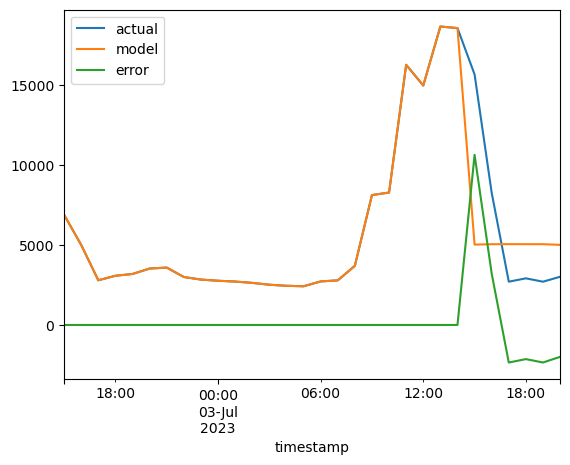

In [68]:
timestamp_validation = pd.Timestamp(year=2023, month=7, day=3, hour=15, tz=TIMEZONE)
collect_simulation_on_timestamp_results(simulate_on_timestamp(model_alex_GRU, 
                                       df_test, timestamp_validation, HISTORY_LENGTH_Alex, FORECAST_LENGTH_Alex)).plot()

In [69]:
assessment_result_df = simulate_on_timeseries(model_alex_GRU, df_test, HISTORY_LENGTH_Alex, FORECAST_LENGTH_Alex)

100%|██████████| 3529/3529 [02:16<00:00, 25.78it/s]


In [70]:
assessment_result_df.mean()

/tmp/ipykernel_19920/152922769.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  assessment_result_df.mean()


RMSE           2.880032e+07
R2            -7.164481e+01
R2_2          -7.164481e+01
MAE            3.318357e+03
MAPE           5.329058e-01
SMAPE          4.883006e-01
corr           2.519688e-01
errors_0       1.333064e+03
actuals_0      6.119748e+03
forecasts_0    4.786684e+03
errors_1       1.308686e+03
actuals_1      6.119396e+03
forecasts_1    4.810709e+03
errors_2       1.304730e+03
actuals_2      6.121436e+03
forecasts_2    4.816706e+03
errors_3       1.306425e+03
actuals_3      6.120108e+03
forecasts_3    4.813684e+03
errors_4       1.305788e+03
actuals_4      6.121082e+03
forecasts_4    4.815294e+03
errors_5       1.343700e+03
actuals_5      6.121528e+03
forecasts_5    4.777829e+03
dtype: float64

In [71]:
metrics_Alex = collect_metrics(assessment_result_df, FORECAST_LENGTH_Alex)

In [72]:
metrics_Alex

,ME,MAE,MAPE,SMAPE,RMSE,STD,R2,corr
0,1333.064156,3402.304108,0.554276,0.499226,5457.777536,5292.473485,0.107417,0.497786
1,1308.686288,3289.945588,0.527218,0.480915,5346.306566,5183.660299,0.143327,0.576577
2,1304.729654,3218.859174,0.507142,0.468672,5289.557490,5126.119289,0.162504,0.619862
3,1306.424658,3206.354075,0.503260,0.466623,5281.103522,5116.962871,0.166071,0.626987
4,1305.788016,3293.716539,0.528180,0.484881,5331.860332,5169.492457,0.150728,0.592870
5,1343.699910,3498.960938,0.577360,0.529488,5489.390833,5322.394411,0.099985,0.483260


In [73]:
# Sample plotting
...

# SARIMAX

In [33]:
HISTORY_LENGTH_SARIMAX = 7*24
FORECAST_LENGTH_SARIMAX = 24

In [25]:
model_SARIMAX = SARIMAXBasedModel(VALUE_COLUMN, 24, FORECAST_LENGTH_SARIMAX)

In [26]:
model_SARIMAX.set_parameters(p=4, d=1, q=4, P=0, D=1, Q=1) # TODO optimise hyper parameters

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_SARIMAX.fit(df_train[-3000:])

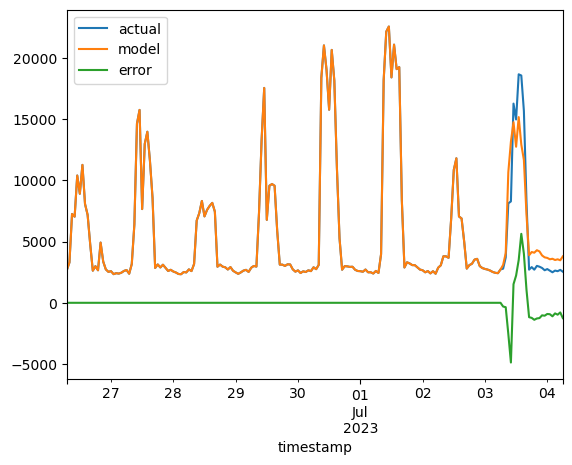

In [34]:
timestamp_validation = pd.Timestamp(year=2023, month=7, day=3, hour=7, tz=TIMEZONE)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    collect_simulation_on_timestamp_results(simulate_on_timestamp(model_SARIMAX, 
                                       df_test, timestamp_validation, HISTORY_LENGTH_SARIMAX, FORECAST_LENGTH_SARIMAX)).plot()

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    assessment_result_df = simulate_on_timeseries(model_SARIMAX, df_test, HISTORY_LENGTH_SARIMAX, FORECAST_LENGTH_SARIMAX)

100%|██████████| 3529/3529 [03:14<00:00, 18.19it/s] 


In [36]:
assessment_result_df

,timestamp,RMSE,R2,R2_2,MAE,MAPE,SMAPE,corr,errors_0,actuals_0,...,forecasts_20,errors_21,actuals_21,forecasts_21,errors_22,actuals_22,forecasts_22,errors_23,actuals_23,forecasts_23
0,2023-05-08 00:00:00+07:00,2.378339e+07,0.536745,0.536745,2877.812478,0.251804,0.276778,0.760977,-274.756797,2785.358,...,3230.615318,216.437086,3281.061,3064.623914,56.569654,3013.429,2956.859346,114.397100,2957.640,2843.242900
1,2023-05-08 01:00:00+07:00,2.385364e+07,0.535796,0.535796,2861.612276,0.242962,0.269646,0.762247,-154.702268,2468.380,...,3035.358206,87.967138,3013.429,2925.461862,142.877375,2957.640,2814.762625,-8.253590,2676.003,2684.256590
2,2023-05-23 10:00:00+07:00,1.275126e+07,0.736320,0.736320,2605.058715,0.553559,0.425180,0.922746,6202.792262,20369.513,...,4061.532650,-1219.161995,2757.794,3976.955995,1123.368562,7670.864,6547.495438,2090.390681,16842.622,14752.231319
3,2023-05-23 11:00:00+07:00,1.101108e+07,0.753845,0.753845,2670.815185,0.664158,0.465763,0.895923,-2656.144566,18176.094,...,4220.873695,878.977933,7670.864,6791.886067,1846.828329,16842.622,14995.793671,-1950.317368,16691.255,18641.572368
4,2023-05-23 12:00:00+07:00,1.069077e+07,0.759668,0.759668,2372.626357,0.583242,0.425881,0.897668,-586.951890,11455.423,...,6648.106676,1988.444402,16842.622,14854.177598,-1814.353391,16691.255,18505.608391,81.518987,17914.534,17833.015013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2283,2023-10-04 13:00:00+07:00,1.985038e+07,0.735512,0.735512,3322.495677,0.477580,0.367606,0.903438,15742.625460,41428.869,...,15978.149519,-2437.122643,16024.065,18461.187643,-5480.309434,12450.607,17930.916434,-5685.479141,10006.421,15691.900141
2284,2023-10-04 14:00:00+07:00,3.571660e+07,-0.024259,-0.024259,5275.641836,0.827734,0.551379,0.957810,-11448.583697,25248.151,...,19392.719744,-6386.812428,12450.607,18837.419428,-6597.005670,10006.421,16603.426670,-5546.259200,19655.796,25202.055200
2285,2023-10-04 15:00:00+07:00,1.363499e+07,0.509091,0.509091,3288.918391,0.578346,0.417520,0.953291,-1970.013329,17386.370,...,18467.292197,-6245.074155,10006.421,16251.495155,-5217.298322,19655.796,24873.094322,145.010381,19371.399,19226.388619
2286,2023-10-04 16:00:00+07:00,1.311499e+07,0.523199,0.523199,3168.621352,0.566190,0.409223,0.944396,-3296.726097,9079.722,...,16348.792591,-5320.612489,19655.796,24976.408489,21.899130,19371.399,19349.499870,383.922091,17047.811,16663.888909


In [37]:
metrics_SARIMAX = collect_metrics(assessment_result_df, FORECAST_LENGTH_SARIMAX)

In [38]:
metrics_SARIMAX

,ME,MAE,MAPE,SMAPE,RMSE,STD,R2,corr
0,-341.475898,1222.916157,0.222234,0.192167,2164.968321,2137.868574,0.846794,0.923186
1,-409.551077,1748.744660,0.330593,0.271795,2949.610759,2921.039463,0.714456,0.850538
2,-459.399964,1964.216564,0.380963,0.306574,3235.998477,3203.223036,0.654330,0.816148
3,-487.928011,2056.441126,0.406472,0.324374,3356.472831,3320.818592,0.627796,0.800638
4,-516.258353,2120.563707,0.424314,0.334013,3444.149406,3405.237502,0.606426,0.788308
5,-529.644621,2171.814481,0.437589,0.342196,3501.567887,3461.279278,0.593985,0.780581
6,-533.631043,2202.727619,0.446489,0.348199,3530.467509,3489.905262,0.588742,0.777287
7,-537.548473,2211.638288,0.450314,0.350881,3542.879199,3501.861599,0.585229,0.775389
8,-545.268693,2214.288630,0.452972,0.353050,3542.592390,3500.377536,0.585058,0.775813
9,-548.060720,2216.179448,0.454164,0.354119,3548.756840,3506.180907,0.583882,0.775550


# Holt-Winters

# LSTNet

# Save